In [ ]:
import glob
import pandas as pd
import shutil 
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
%matplotlib inline
import torch
import torch.nn as nn
from torchvision import models
from torch.hub import load_state_dict_from_url
from PIL import Image
import cv2
import numpy as np
from matplotlib import pyplot as plt


In [ ]:
import albumentations as A
import cv2
import tensorflow as tf

In [ ]:
from google.colab import files
import os
import zipfile
import io

#uploaded = files.upload()
os.listdir('.')

['.config', 'drive', 'sample_data']

In [ ]:
zf = zipfile.ZipFile(io.BytesIO(uploaded['weld_images.zip']), "r")
zf.extractall()
os.listdir('.')

['.config',
 'weld_images.zip',
 'resnet_imagenet_weight.h5',
 'weld_images',
 'sample_data']

In [ ]:
len(os.listdir('weld_images/defect_free'))

111

In [ ]:
def preprocess(img):
  img = load_img(img, target_size = (400,400)) 
  img = img_to_array(img) 
  
  processed_image = tf.keras.applications.resnet.preprocess_input(img.copy()) 
  #plt.imshow(processed_image)
  return processed_image


In [ ]:
import random
import cv2
import glob
h,w = 400,400

train_files1 = glob.glob('weld_images/defective' + '/*.jpg') 
random.shuffle(train_files1)
train_files2 = glob.glob('weld_images/defect_free' + '/*.jpg')
random.shuffle(train_files2)

#train_defect = [cv2.resize(cv2.imread(img),(w,h)) for img in train_files1]
#train_defect_free = [cv2.resize(cv2.imread(img),(w,h)) for img in train_files2]
train_defect = [preprocess(img) for img in train_files1]
train_defect_free = [preprocess(img) for img in train_files2]

In [ ]:
#train_labels = [1 for fn in train_files1]+[0 for fn in train_files2]
train_labels = [np.array([1, 0]) for fn in train_files1]+[np.array([0, 1]) for fn in train_files2]

In [ ]:
train_imgs = train_defect+train_defect_free
train_data=[]
for i in range(0,len(train_labels)):
  train_data.append([train_imgs[i],train_labels[i]])

random.shuffle(train_data)

In [ ]:
imgs_train=[]
labels_train=[]
for i in range(len(train_data)):
  imgs_train.append(train_data[i][0])
  labels_train.append(train_data[i][1])

imgs_train=np.array(imgs_train)
labels_train=np.array(labels_train)

#imgs_train = imgs_train/255

In [ ]:
import tensorflow as tf
import keras
from tensorflow.keras.applications import ResNet50
from keras.preprocessing.image import image
from keras.preprocessing.image import img_to_array
from keras.applications.resnet import preprocess_input
from keras.applications.imagenet_utils import decode_predictions
#from keras.applications.resnet import ResNet50 
import matplotlib.pyplot as plt

# Initialize the Pretrained Model
feature_extractor = ResNet50(weights='imagenet', 
                             input_shape=(400, 400, 3),
                             include_top=False)

# Set this parameter to make sure it's not being trained
feature_extractor.trainable = False

# Set the input layer
input_ = tf.keras.Input(shape=(400, 400, 3))

# Set the feature extractor layer
x = feature_extractor(input_, training=False)

# Set the pooling layer
x = tf.keras.layers.GlobalAveragePooling2D()(x)

#x = tf.keras.layers.BatchNormalization()(x)
#x = tf.keras.layers.Dropout(0.2)(x)

# Set the final layer with sigmoid activation function
output_ = tf.keras.layers.Dense(2, activation='sigmoid')(x)

# Create the new model object
model1 = tf.keras.Model(input_, output_)

# Compile it
model1.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

# Print The Summary of The Model
model1.summary()



94781440/94765736 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 400, 400, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 13, 13, 2048)      23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                                 
Total params: 23,591,810
Trainable params: 4,098
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
model1.fit(imgs_train,labels_train,batch_size=14,epochs=1,verbose=1, validation_split=0.2)

21/21 [==============================] - 171s 8s/step - loss: 0.1456 - accuracy: 0.9683 - val_loss: 0.1701 - val_accuracy: 0.9444


In [ ]:
classify = tf.keras.models.load_model('/content/resnet_imagenet_weight.h5')

OSError: ignored

In [ ]:
def predict(image):
  cv2_form = cv2.imread(image)
  img = load_img(image, target_size = (400,400)) 
  img = img_to_array(img) 
  img = np.expand_dims(img, axis = 0)
  processed_image = tf.keras.applications.resnet.preprocess_input(img.copy()) 
  preds = classify.predict(processed_image) 
  if preds[0][0]>preds[0][1]:
    cv2.putText(cv2_form, 'Defective',(10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)
    print("Class: Defective,  Score: "+str(preds[0][0]))
  else:
    cv2.putText(cv2_form, 'Defect-Free',(10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
    print("Class: Defect-Free,  Score: "+str(preds[0][1]))
  plt.imshow(cv2_form)
  #return preds

Class: Defective,  Score: 0.81912184


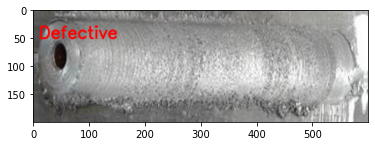

In [ ]:
#from augmented images
predict("weld_images/defective/aug_72.jpg")      #Defective

Class: Defective,  Score: 0.9977026


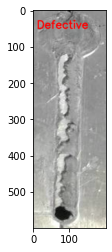

In [ ]:
predict("weld_images/defective/175.jpg")    #Defective

Class: Defective,  Score: 0.9760343


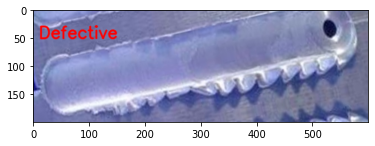

In [ ]:
predict("weld_images/defective/aug_109.jpg")      #Defective

Class: Defective,  Score: 0.66156363


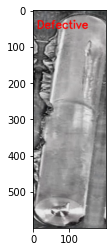

In [ ]:
predict("weld_images/defective/aug_194.jpg")    #defect-free

Class: Defect-Free,  Score: 0.92419577


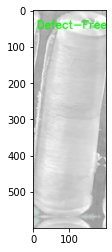

In [ ]:
predict("weld_images/defect_free/aug_defect_free14.jpg")    #defect-free

Class: Defect-Free,  Score: 0.98879635


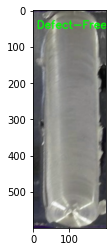

In [ ]:
predict("weld_images/defect_free/aug_defect_free50.jpg")   #defect-free

Class: Defect-Free,  Score: 0.76133823


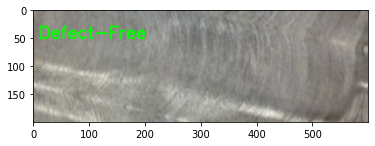

In [ ]:
predict("weld_images/defect_free/aug_defect_free98.jpg")   #defect-free

Class: Defect-Free,  Score: 0.95949036


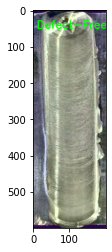

In [ ]:
predict("weld_images/defect_free/aug_defect_free69.jpg")  #defect-free

Class: Defect-Free,  Score: 0.87997454


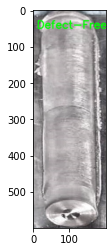

In [ ]:
predict("weld_images/defect_free/aug_defect_free4.jpg")  #defect-free

Class: Defect-Free,  Score: 0.9599166


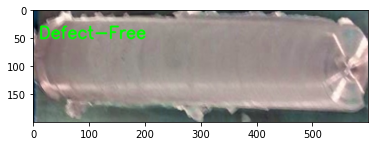

In [ ]:
predict("weld_images/defect_free/aug_defect_free40.jpg")

In [ ]:
##Sample outputs (google images)

Class: Defective,  Score: 0.8204367


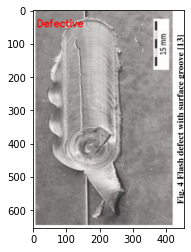

In [ ]:
predict('def1.jpg')

Class: Defective,  Score: 0.99648225


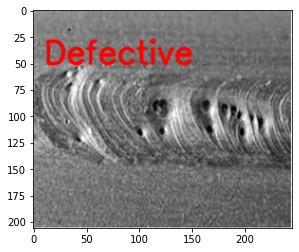

In [ ]:
predict('def3.jpg')

Class: Defective,  Score: 0.9709338


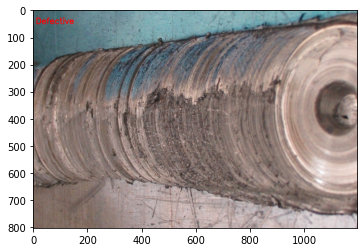

In [ ]:
predict('def2.jpg')

Class: Defect-Free,  Score: 0.98760146


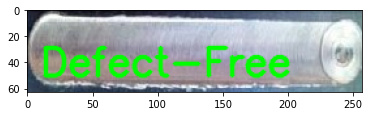

In [ ]:
predict('nodef2.jpg')

Class: Defect-Free,  Score: 0.90423656


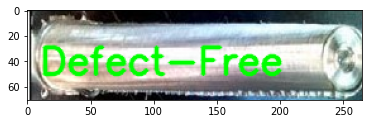

In [ ]:
predict('nodef1.jpg')

In [ ]:
model1.save("resnet_imagenet_weight2.h5")

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
keras.__version__

'2.7.0'